<a href="https://colab.research.google.com/github/KarelZe/adv-ml/blob/main/AML_Bonus_Model_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebooks for testing models only


In [51]:
%%capture
!pip install -U imbalanced-learn
!pip install -U yellowbrick
!pip install catboost

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, LogisticRegression, lasso_path
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    matthews_corrcoef,
    plot_confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from yellowbrick.classifier.rocauc import roc_auc
# wraps third party clfs
from yellowbrick.contrib.wrapper import classifier

from catboost import CatBoostClassifier, Pool

# apply some custom styling to charts
sns.set_theme(style="whitegrid", palette="rocket", font_scale=1.1, color_codes=True)
cmap = sns.cm.rocket

import matplotlib.pyplot as plt
%matplotlib inline

# increase the number of rows displayed to fully display all (transposed) features.
pd.options.display.max_rows = 1000


## Loading the data

In [53]:
drive.mount("/content/drive")

# load proprocessed data
X_train = pd.read_pickle("/content/drive/My Drive/AdvancedML/X_train.pkl")
y_train = pd.read_pickle("/content/drive/My Drive/AdvancedML/y_train.pkl")

X_test = pd.read_pickle("/content/drive/My Drive/AdvancedML/X_test.pkl")
y_test = pd.read_pickle("/content/drive/My Drive/AdvancedML/y_test.pkl")    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)


y_train.head()

,TARGET
0,0
1,0
2,0
3,0
4,0


## Task 3: Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression. (20 points)

To compare the models in the end a DataFrame storing the performance metrics is created.

In [55]:
performance = pd.DataFrame()

## Task 4: Compare logistic regression, classification tree, random forest, bagging, support vector machine (with two kernel functions), and neural network for default prediction based on the out-of-sample performance measures (at least three different measures). (35 points)

### Preliminary

For model evaluation the same performance metrics are calculated. In contrast to the in-sampling method for Logistic Regression an out-of-sample approach is used by using separated data for training and testing.

In [56]:
def print_results(model, performance):
    y_pred_model = model.predict(X_test)

    print(classification_report(y_test, y_pred_model))

    fig, ax = plt.subplots(figsize=(16, 9))
    disp = plot_confusion_matrix(model, X_test, y_test, display_labels=['Non-Default', 'Default'], ax=ax)
    plt.title(f"Confusion matrix for {model.__class__.__name__}")
    disp.ax_.grid(False)
    plt.show()

    print(f"Accuracy: {accuracy_score(y_test, y_pred_model):.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_model):.2f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred_model):.2f}")
    print()
    print(f"Params: {model.get_params()}")

    performance_metrics = pd.DataFrame({'Accuracy': accuracy_score(y_test, y_pred_model),
                                        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_model),
                                        'Matthews Corrcoef': matthews_corrcoef(y_test, y_pred_model)},
                                       index=[f"{model.__class__.__name__}"])
    performance = performance.append(performance_metrics)
    return performance

In [57]:
# based on https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html
def print_performance_measures(model):
    # Instantiate the visualizer with the classification model
    plt.figure(figsize=(9, 9))
    # FIXME: binary flag not working. Figure out why.
    roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=["Default", "Non-Default"], binary=True)
    plt.show()

### Decision Tree

In [58]:
# # max_depth = [2, 6, 10, 14...]
# min_depth = 2
# step_size = 4
# step_count = 2 ** 4
# max_depth = min_depth + np.arange(step_count) * step_size

# # perform grid search
# param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': max_depth}
# grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, verbose=0, n_jobs=-1)
# grid_dt.fit(X_train, y_train)

# # choose best model
# grid_dt_optimized = grid_dt.best_estimator_

# # print confusion 
# performance_metrics = print_results(grid_dt_optimized, performance)

# print_performance_measures(grid_dt_optimized)

In [59]:
performance

""


### Plot Decision Tree

In [60]:
# fig, ax = plt.subplots(figsize=(16, 9))
# tree.plot_tree(grid_dt_optimized, feature_names=X_train.columns, proportion=True, max_depth=2);

### Plot feature importances of Decision Tree

In [86]:
def print_feature_importance(feature_importance, clf):
    """
    function to create a paretto plot with the gini importance of features.
    """
    feature_importance.sort_values(ascending=False, inplace=True, by=0)

    feature_importance['pareto'] = 100 * feature_importance[0].cumsum() / feature_importance[0].sum()
    feature_importance.rename(columns={0: 'importance'}, inplace=True)

    fig, axes = plt.subplots(figsize=(16, 9))
    ax1 = feature_importance.plot(use_index=True, y='importance', kind='bar', ax=axes, color=cmap(0.1))
    ax2 = feature_importance.plot(use_index=True, y='pareto', marker='D', color=cmap(0.7), kind='line', ax=axes,
                                  secondary_y=True)
    ax2.set_ylim([0, 110])
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.xticks(rotation=45)
    plt.title(f"feature importances given by '.feature_importances_' for {clf.__class__.__name__}")
    plt.show()


 
# importance = grid_dt_optimized.feature_importances_
# feature_importance = pd.DataFrame(importance, X_train.columns)

# print_feature_importance(feature_importance, grid_dt_optimized)

### Random Forest

In [62]:
# # [6, 10, 14...]
# max_depth = np.arange(6, 22, 4)
# # [5, 10, 25, 50, 100, 150]
# n_estimators = [5, 25, 50, 100, 150]

# # perform grid search
# param_grid = {'criterion': ['entropy'], 'max_depth': max_depth, 'n_estimators': n_estimators}
# grid_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, refit=True, verbose=0, n_jobs=-1)
# grid_rf.fit(X_train, y_train.values.ravel())

# # choose best model
# grid_rf_optimized = grid_rf.best_estimator_

# # print confusion 
# performance = print_results(grid_rf_optimized, performance)

# print_performance_measures(grid_rf_optimized)

In [63]:
performance

""


### Bagging

In [64]:
# param_grid = {
#     'base_estimator__max_depth' : [1, 2, 3, 4, 5],
#     'max_samples' : [0.05, 0.1, 0.2, 0.5]
# }

# grid_bag = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
#                                      n_estimators = 100, max_features = 0.5, n_jobs=-1),
#                    param_grid, n_jobs=-1)
# grid_bag.fit(X_train, y_train.values.ravel())


# # choose best model
# grid_bag_optimized = grid_bag.best_estimator_

# # print confusion 
# performance = print_results(grid_bag_optimized, performance)
# print_performance_measures(grid_bag_optimized)

In [65]:
performance

""


### Support Vector Machine

Next, we look at SVM with two different kernels. Namely, a rfb kernel and linear kernel.

In [66]:
# # min_c = 0.1
# # step_size = 0.1
# # step_count = 15

# # C = min_c + np.arange(step_count) * step_size

# # param_grid = {'C': [0.1, 1], 'gamma': [1, 0.1], 'kernel': ['linear','rbf', ]}

# param_grid = {'C': [0.1], 'kernel': ['linear','sigmoid'], 'max_iter':[20000]}
# grid_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=0, n_jobs=-1)
# grid_svm.fit(X_train, y_train.values.ravel())

# # choose best model
# grid_svm_optimized = grid_svm.best_estimator_

# # print confusion 
# performance = print_results(grid_svm_optimized, performance)

# print_performance_measures(grid_svm_optimized)

In [67]:
performance

""


### Neural Network 

In [68]:
# param_grid = {'activation': ['logistic', 'relu'],
#               'hidden_layer_sizes': [(100, 1), (100, 2)], 'early_stopping': [True]}
# grid_nn = GridSearchCV(MLPClassifier(), param_grid, refit=True, verbose=0, n_jobs=-1)
# grid_nn.fit(X_train, y_train.values.ravel())

# # choose best model
# grid_nn_optimized = grid_nn.best_estimator_

# # print confusion 
# performance = print_results(grid_nn_optimized, performance)

# print_performance_measures(grid_nn_optimized)

In [69]:
performance

""


## Boosting Ansatz

In [70]:
#clf_cat = CatBoostClassifier(iterations=100)
#parameters = {'learning_rate': [0.03, 0.1, 0.3] ,'depth': [12]}

clf_cat = CatBoostClassifier(iterations=1)
parameters = {'learning_rate': [0.03] ,'depth': [1]}

# perform grid search
grid_cat = GridSearchCV(clf_cat,
                    parameters, n_jobs=-1,
                    scoring="neg_log_loss",
                    cv=3)


eval_set = [(X_train, y_train), (X_test, y_test)]
grid_cat.fit(X_train, y_train, eval_set=eval_set) 

grid_cat_optimized = grid_cat.best_estimator_



0:	learn: 0.6662101	test: 0.6662101	test1: 0.6659010	best: 0.6659010 (0)	total: 60ms	remaining: 0us

bestTest = 0.6659010198
bestIteration = 0



              precision    recall  f1-score   support

           0       0.98      0.89      0.93     29482
           1       0.54      0.88      0.67      4428

    accuracy                           0.89     33910
   macro avg       0.76      0.88      0.80     33910
weighted avg       0.92      0.89      0.90     33910



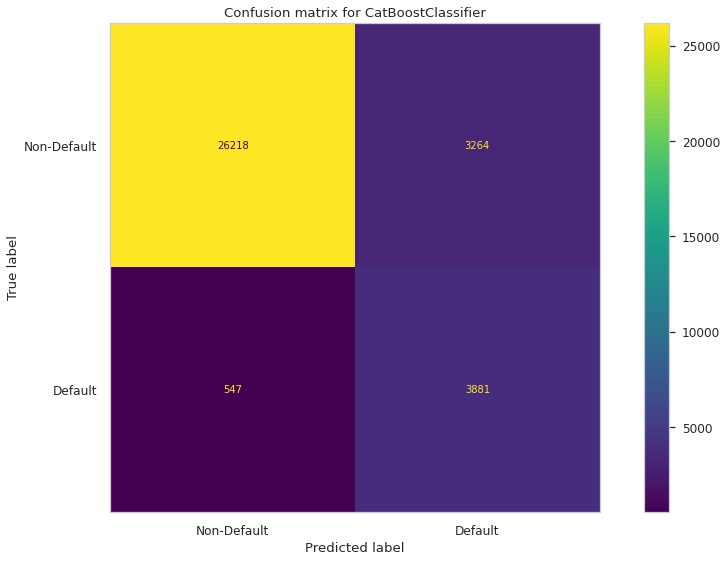

Accuracy: 0.89
Balanced Accuracy: 0.88
MCC: 0.63

Params: {'iterations': 1, 'learning_rate': 0.03, 'depth': 1}


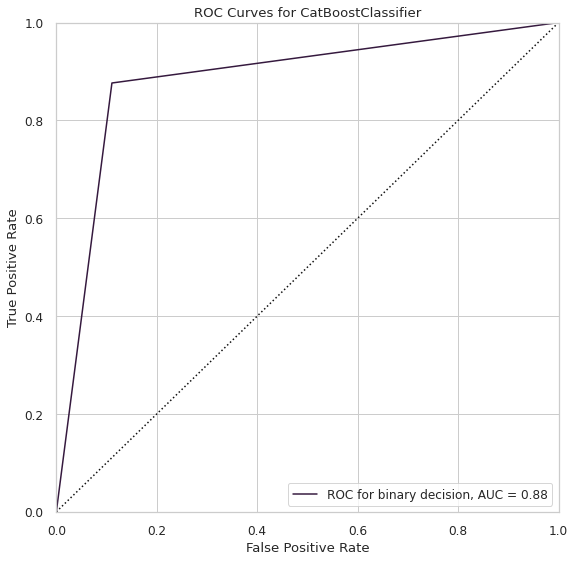

In [71]:
performance = print_results(grid_cat_optimized, performance)

print_performance_measures(classifier(grid_cat_optimized))

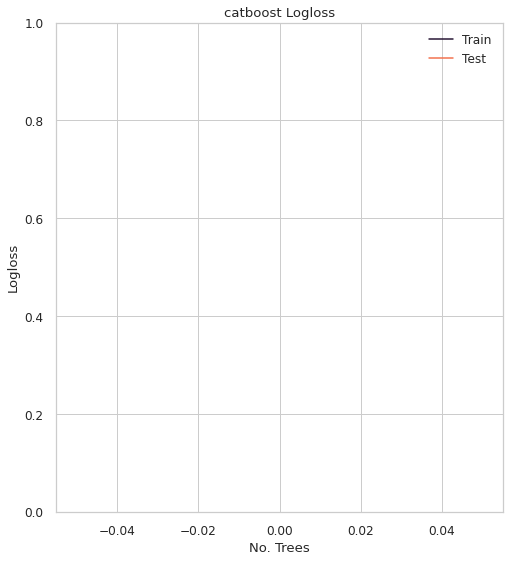

In [72]:
# create lineplot showing improvement lof logloss
results = grid_cat_optimized.evals_result_
epochs = len(results['validation_0']['Logloss'])
x_axis = range(0, epochs)
plt.figure(figsize=(8,9))
sns.lineplot(x=x_axis, y=results['validation_0']['Logloss'], label='Train', color=cmap(0.1))
sns.lineplot(x=x_axis, y=results['validation_1']['Logloss'], label='Test', color=cmap(0.7))
plt.legend()
plt.ylim((0,1))
plt.ylabel('Logloss')
plt.title('catboost Logloss')
plt.xlabel('No. Trees')
plt.show()

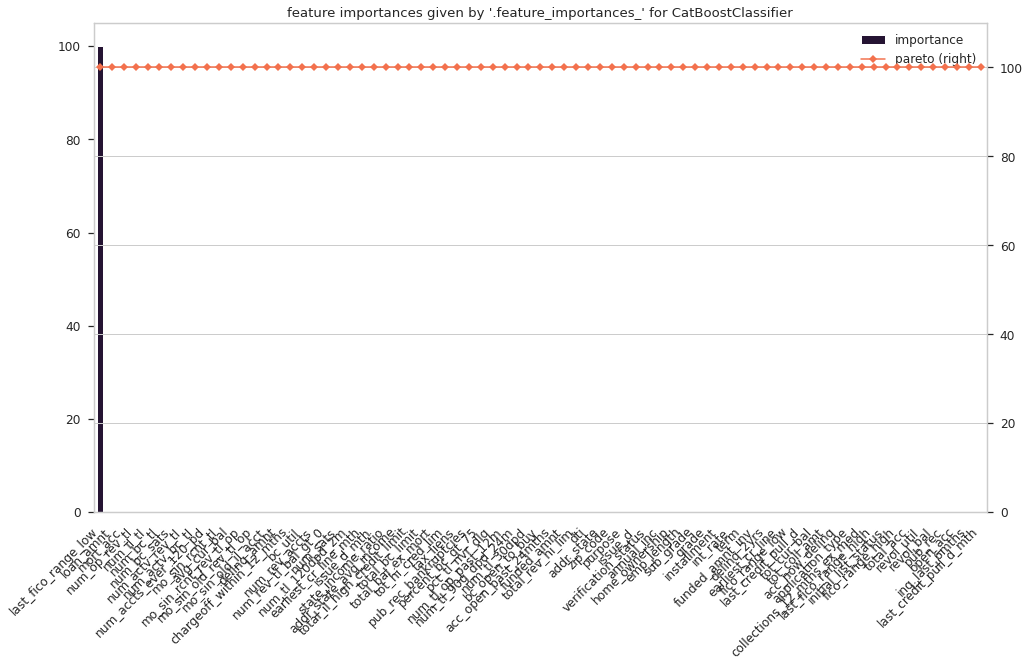

In [87]:
importance = grid_cat_optimized.feature_importances_
feature_importance = pd.DataFrame(importance, X_train.columns)
print_feature_importance(feature_importance, grid_cat_optimized)

## Voting Classifier

In [74]:
# # TODO: Optional. Combine the best Classifiers e. g. SVM and RF
# model_voting = VotingClassifier(estimators=[('SVM', grid_svm_optimized), ('Random Forest', grid_rf_optimized)],
#                                    voting='hard')
# model_voting.fit(X_train, y_train.values.ravel())

# # print confusion matrix
# performance = print_results(model_voting, performance)

# print_performance_measures(model_voting)

## Stacking Classifier

In [75]:
# # TODO: insert Code
# estimators = [('Neural Net', grid_nn_optimized), ('Random Forest', grid_rf_optimized)]
# model_stacked = StackingClassifier(estimators=estimators,
#                                    final_estimator=LogisticRegression(max_iter=200, penalty='l1', solver='liblinear'))

# model_stacked.fit(X_train, y_train.values.ravel())

# performance = print_results(model_stacked, performance)

# print_performance_measures(model_stacked)

Bringing it all together....

##Task 5: Use LASSO for variable selection and explain results. (15 points)

In Task 5 we use a LASSO model for variable selection. First we run a grid search to find a suitable value for the penalty weight $\alpha$. We use the metric Area under the curve (AUC) is the criteria for model selection.

In [76]:
# # TODO: LASSO for classification -> < 0.5 / > 0.5?
# # TODO: Discussion suitable for classifcation / automatic feature selection (pros and cons) 
# # TODO: Move to end

# # use LassoCV to find the optimal alpha
# lasso = LassoCV(cv=5, random_state=0, max_iter=5000).fit(X, y)
# model = SelectFromModel(lasso, prefit=True)
# X_new = model.transform(X)
# print('X shape: ', X_new.shape)
# print('lasso_coef: ', lasso.coef_)
# print('lasso_intercept: ', lasso.intercept_)
# print('lasso_alpha: ', lasso.alpha_)
# lasso_alpha = lasso.alpha_

Next we look at coefficient of the optimized alpha....

In [77]:
# coef_importance = pd.DataFrame(lasso.coef_, index=X.columns)
# coef_importance.rename(columns={0: 'importance'}, inplace=True)
# coef_importance = coef_importance.iloc[(-np.abs(coef_importance['importance'].values)).argsort()]

# fig, axes = plt.subplots(figsize=(16, 9))
# ax1 = coef_importance.plot(use_index=True, y='importance', kind='bar', ax=axes, color=cmap(150), legend=False)
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
# plt.xticks(rotation=45)
# plt.title(f"abs. feature importances given by '.coef' for {model.__class__.__name__}")
# plt.show()

And more general for varying alpha....

In [78]:
# alphas_lasso, coefs_lasso, _ = lasso_path(X, y, n_alphas=20, fit_intercept=False)

In [79]:
# neg_log_alphas_lasso = -np.log10(alphas_lasso)

# # create df with coefs and their importance
# df_test = pd.DataFrame(coefs_lasso[0], index=X.columns)
# df_test.columns = neg_log_alphas_lasso

# # TODO: logscale y axis

# # plot
# plt.figure(figsize=(20, 20))
# g = sns.lineplot(data=df_test.T)
# plt.xlabel('-log(alpha)')
# plt.ylabel('coefficients')
# plt.title('Lasso paths')
# plt.legend(bbox_to_anchor=(1.1, 1))
# plt.show(g);

In [80]:
#performance